Other posts in this series:  

[A Journey Through Fastbook (AJTFB) - Chapter 1](2020-11-06-ajtfb-chapter-1.ipynb)  
[A Journey Through Fastbook (AJTFB) - Chapter 2](2020-11-16-ajtfb-chapter-2.ipynb)  
[A Journey Through Fastbook (AJTFB) - Chapter 3](2020-11-22-ajtfb-chapter-3.ipynb)  
[A Journey Through Fastbook (AJTFB) - Chapter 4](2021-05-23-ajtfb-chapter-4.ipynb)  
[A Journey Through Fastbook (AJTFB) - Chapter 6a](2021-06-10-ajtfb-chapter-6-multilabel.ipynb)  
[A Journey Through Fastbook (AJTFB) - Chapter 6b](2022-02-09-ajtfb-chapter-6-regression.ipynb)  
[A Journey Through Fastbook (AJTFB) - Chapter 7](2022-03-28-ajtfb-chapter-7.ipynb)  
[A Journey Through Fastbook (AJTFB) - Chapter 8](2022-03-31-ajtfb-chapter-8.ipynb)    
[A Journey Through Fastbook (AJTFB) - Chapter 9](2022-04-25-ajtfb-chapter-9.ipynb)    

In [ ]:
#| include: false
!pip install fastai>=2.3 --upgrade

import fastai
from fastai.vision.all import *
print(fastai.__version__ )

2.3.1


## Multiclass vs Multi-label classification ...

Yah, it can be confusing!  

Anyhow, **multiclass classification** is all about predicting a SINGLE CLASS an object belongs to from a list of two or more classes.  It can be a simple as predicting whether an image is a dog or a cat, or as complex as predicting the breed of dog from amongst dozens of potential breeds.  

**Multi-label classification** (covered in the next chapter) involves predicting MULTIPLE CLASSES to which an object belongs; it can belong to one, some, all, or even none of those classes. For example, you may be looking at satellite photos from which you need to predict the different kinds of terrain (your classes) each contains.

## Defining your DataBlock

Again, the `DataBlock` is a blueprint for everything required to turn your raw data (images and labels) into something that can be fed through a neural network (DataLoaders with a numerical representation of both your images and labels).  Below is the one presented in this chapter.



In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                   get_items=get_image_files, 
                   get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                   splitter=RandomSplitter(seed=42),   
                   item_tfms=Resize(460), 
                   batch_tfms=aug_transforms(size=224, min_scale=.75))

**Let's break down our blueprint**!

1. Define the data types for our inputs and targets via the `blocks` argument.

  This is defined as a tuple, where we tell our `DataBlock` that the imputs are images and our targets are a single category (or class or label).

2. Define how we're going to get our raw data via `get_items`.

  We use `get_image_files` because we are getting image files from the filesystem.  When we kick off the `DataBlock` to build our `DataLoaders`, we'll pass in the path to our images which will in turn be passed to `get_image_files` to pull the raw data.

3. Define how, from the raw data, we're going to create our labels (e.g., the classes for each image) via `get_y`.

  In this case, we don't need to define a `get_x` because `get_items` gets the x's already.  However, since we are working with filenames from which we want to define our labels, we do need this fancy `get_y` function above. `using_attr` tells the `RegexLabeller` what attribute of our data to apply itself too, and since our data is filenames, we tell it to use the `.name` property of each filename object as the thing the `RegexLabeller` acts against.  That will give us our target class.

4. Define how we're going to create our [validation dataset](https://www.fast.ai/2017/11/13/validation-sets/) via `splitter`

5. Define things we want to do for each item via `item_tfms`

  `item_tfms` are transforms, or things we want to do, to each input individually!  Above we only have one which says, "Resize each image to 460 max width/height" one by one *when we grab it*.  For individual images to be collated into mini-batches, they have to be the same size ... thus we do this here and not below.

6. Define things we want to do for each mini-batch of items via `batch_tfms`

  `batch_tfms` are transforms, or things we want to do, *to a mini-batch of inputs* at once *on the GPU*.  `aug_transforms` includes a bunch that have proven to be effective in computer vision tasks. With the parameters we're passing into it above (`size=224, min_scale=.75`), we're saying, "Take the mini-batch of images here and randomly crop the 460x460 images to be 224x224 that captures at least 3/4 of the image".  See here for more info on [`RandomResizedCrop`](https://docs.fast.ai/vision.augment.html#RandomResizedCrop).

:::{.callout-important}

If you can describe your `DataBlock` like I have above, you understand it!

:::

:::{.callout-important}

Verify your `DataBlock` works as expected, or else troubleshoot it, by running `DataBlock.summary(data)`

:::

In [ ]:
dblock.summary(path/'images')

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Bombay_111.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=604x453
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Bombay_111.jpg
    applying partial gives
      Bombay
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(3)

Final sample: (PILImage mode=RGB size=604x453, TensorCategory(3))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: 

Now we can create our `DataLoaders` and take a look at our x's and y's, our pet images and their label/class

In [ ]:
dls = dblock.dataloaders(path/'images')
dls.show_batch()

To get a feel for what our `batch_tfms` are doing, we can `show_batch` using a single image as we do below.

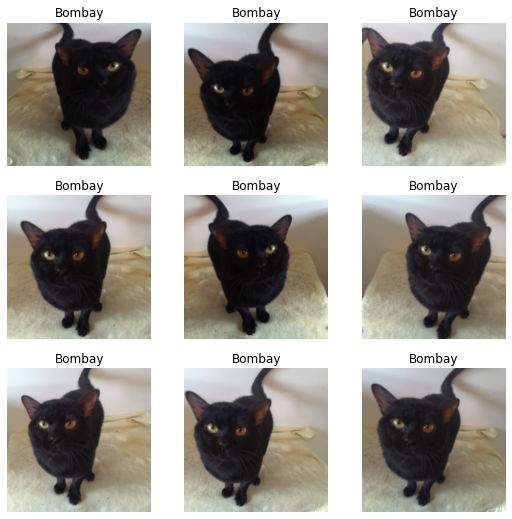

In [ ]:
dls.show_batch(unique=True)

The combination of what we're doing in the `item_tfms` and `batch_tfms` is known as **presizing**.  

"Presizing is a particular way to do iamge augmentation taht is designed to minimize data destruction while maintaining good performance."  After resizing all the images to a larger dimension that we will train on, we perform all our core augmentations on the GPU.  This results in both faster and less destructive transformations of the data.

:::{.callout-important}

See pp190-191 for how these augmentations are applied to the training and validation set!

:::

## Train a model

:::{.callout-important}

"Once you think your data looks right, we generally recommend the next step should be using it to train a simple model" See bottom of p193 for why.

:::

#### Define your loss function

To train a model we need a good loss function that will allow us to optimize the parameters of our model. For multiclassification tasks where we want to predict a single class/label, to go to is **cross-entropy loss**

To understand how this particular loss function operates and its interesting effects, see my prior article ["Loss Functions: Cross Entropy Loss and You!"](https://ohmeow.com/posts/2020/04/04/understanding-cross-entropy-loss.html) It's all about how it works, why use it over something like accuracy, and so forth. Pages 194-203 is the place to look in fastbook for more details on the ins and outs of this loss function.

:::{.callout-important}

Cross-entropy loss is the Highlander of loss functions ... "there can only be one"

:::

"Intuitively, the softmax function *really* wants to pick one class ... so it's ideal for training a classifier when we know each piecture has a definite label. (Note taht it may be less ideal during inference, as you might want your model to sometimes tell you it doesn't recognize any of the classes taht is has seen during training, and not pick a class because it has a slightly bigger activation score. In this case, it might be better to train a model using multiple binary output columns, each using a sigmoid activation.)"

### Train a model

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

:::{.callout-important}

Use the Learning Rate Finder to determine a good LR to use during the optimization step!

:::

"One of the most importatn things we can do when training a model is to make sure that we have the right learning rate. If our learning rate is too low, it can take many, many epochs to train our model ... also that we may have problems with overfitting, ceacuse every time we do a complete pass through the data, we give our model a chance to memorize it"

See p 205-206 for more information on how it works, and also [Leslie Smith's paper on it here](https://arxiv.org/abs/1506.01186).  A must read for fastai developers!!!

In [ ]:
lr_min, lr_steep = learn.lr_find()

In [ ]:
lr_min, lr_steep

(0.010000000149011612, 0.0063095735386013985)

:::{.callout-important}

Pick either "one order of magnitude less that where the minimum loss was achieved" (`lr_min` above, which is actually the true minimum, roughly 1e-1 / 10, 0.01 or else 1e-2) -or- "the last point where the loss was clearly decreasing"

:::

These two are likely close to one another, and if you're not sure which to use, try them both!

In [ ]:
learn.fine_tune(2, base_lr=1e-2)

Using `fine_tune` gives us a nice and quick baseline we can look back at going forward.  Nevertheless, we can likely improve our model by taking more control over what parameters are trained (updated), when, and by how much using `fit_one_cycle`.

So let's start again, by defining our `Learner` and finding a good LR for training ONLY the last layer's parameters (the idea being that the pretrained model we're finetuning, our backbone, is already pretty good at understanding images ... while the last layer's parameters are random because they are specific to our task at hand).

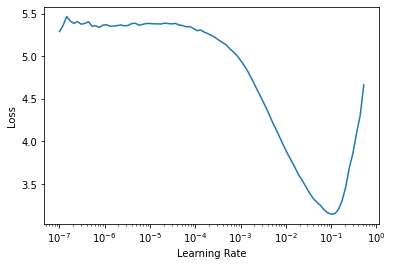

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min, lr_steep = learn.lr_find()

In [ ]:
learn.fit_one_cycle(2, lr_max=1e-2)

NOW ... we're going to "unfreeze" our model, meaning we're going to make all the parameters trainable.  And then we're going to apply **discriminative learning rates**, or different base LRs to different parts of our models, with the assumption that earlier layers likely only need to change a little while later layers, especially our classification head, have to change more. This is covered thoroughly in another must read paper, [Universal Language Model Fine-tuning for Text Classification](https://arxiv.org/abs/1801.06146)

Look at the bottom of the cell below's output to see the number of traininable parameters for our currently frozen model.

In [ ]:
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

Let's unfreeze and look at the same ...

In [ ]:
learn.unfreeze()
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                      

... and as you can see, we're training everything!

Because what parameters were training has changed, we also need to run the LR finder again to get some guidance on how to set our LRs.

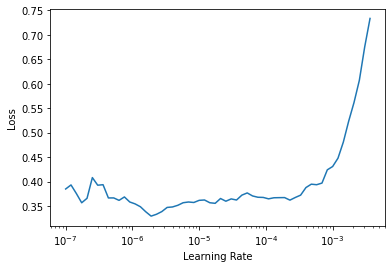

In [ ]:
lr_min, lr_steep = learn.lr_find()

So lets see how many **parameter/layer groups** we have

In [ ]:
len(learn.opt.param_groups)

3

What we can now do is say, train the first layer group with an LR of 1e-6 ... the last with an LR of 1e-4, and "the layers in between will have learning rates that are multiplicatively equidistnat throughout that range."  Since we only have 3, the middle group will be trained with a starting LR of 1e-5

:::{.callout-important}

We usually choose the first number a bit back from where things start to go bad ... and the last number 1-2 magnitudes lower than the base LR of the frozen model

:::

In [ ]:
learn.fit_one_cycle(12, lr_max=slice(1e-6, 1e-4))

In [ ]:
learn.recorder.plot_loss()

:::{.callout-important}

Overfitting does not mean your model isn't improving!

:::

"You will often see that the accuracy continues improving, even as the validation loss gets worse. ***In the end, what matters is your accuracy [or your chosen metric], not the loss.*** The loss is just the function we've given the computer to help us to optimize"


**How to choose the number of epochs?**

:::{.callout-important}

"Your first approach to training should be to simply pick a number of epochs that will train in the amount of time that you are happy to wait for."

:::

If the model is still getting better, then you haven't trained your model long enough.

If your metric(s) are getting worse, "if you find that you have overfit, ***what you should do is retrain your model from scratch, and this time select a total number of epochs based on where your previous best results were found.***"

**When to choose a deeper architecture?**

"A larger (more layers and parameters; sometimes described as the *capacity* of a model) version of ResNet will always be able to give us a better training loss, but it can suffer more from overfitting, because it has more parameters to overfit with.  In general, a bigger model has the ability to better capture the real underlying relationships in your data, as well as to capture and memorize the specific details of your individual images."

So consider these if ...
1. You aren't getting the results you need.
2. Have time to experiment and a big enough GPU to experiment with

You may need to reduce the size of your batches with these bigger models, and you can also us **mixed-precision training**, in order to get things to run on your GPU.  The later results in faster training and gives you the ability to have bigger batch sizes than you would be able to support otherwise.  All you need to do is add `to_fp16()` to your `Learner.

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


## Summary

Well, at this point, you know how to train a multiclassification computer vision task.  So, go train one for yourself using what you've learned!

Make sure you understand and why we use cross-entropy loss for multiclassification problems.  I can't tell you how many times I've responded to questions about why someone's model wasn't training only to find out the reason was because they had the wrong loss function.  Know it, love it, use it :)

Also, so much of what fastai incorporates from the LR finder and the `fit_one_cycle`, comes from Leslie Smith's research.  Checkout the "Resources" section below for some of his more influential papers, all of which I've read and encourage the rest of you to read if you want some inside scoop about why fastai works the way it does. I guarantee, reading and studying those papers will make you a better deep learning practioner and a better fastai developer in particular!  You may think you're not ready to start reading academic papers at chapter 5, but believe me, I've been there, and you are :)


## Resources

1. https://book.fast.ai - The book's website; it's updated regularly with new content and recommendations from everything to GPUs to use, how to run things locally and on the cloud, etc...

2. [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186)  

3. [Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120)  

4. [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, momentum, and weight decay](https://arxiv.org/abs/1803.09820)

5. [Universal Language Model Fine-tuning for Text Classification](https://arxiv.org/abs/1801.06146)

6. [fastai: A Layered API for Deep Learning](https://arxiv.org/abs/2002.04688)
